In [1]:
import torch
import numpy as np
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.core.operation import hamiltonian_evolution, hamiltonian_evolution_eig
import copy

from pyqtorch.matrices import generate_ising_from_graph

/Users/joaom/mambaforge/envs/qucint/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Comparing the single hamiltonian evolution
Here we use an Ising hamiltonian over a graph, which is diagonal

In [2]:
N = 8
p = 0.5

graph = nx.fast_gnp_random_graph(N, p)

batch_size = 1
qc = QuantumCircuit(N)
psi = qc.uniform_state(batch_size)
psi_ini = copy.deepcopy(psi)

H_diag = generate_ising_from_graph(graph)

H = torch.diag(H_diag)

qc = QuantumCircuit(N)
psi = qc.uniform_state(batch_size)
psi_ini = copy.deepcopy(psi)

In [3]:
t_range = torch.arange(0, 2*np.pi, 0.1)
wf_save_rk  = torch.zeros((len(t_range),)+tuple(psi.shape)).cdouble()
wf_save_eig = torch.zeros((len(t_range),)+tuple(psi.shape)).cdouble()

In [4]:
import time

start = time.perf_counter()
for i, t in enumerate(t_range):
    t_evo = torch.tensor([t])
    psi = copy.deepcopy(psi_ini)
    hamiltonian_evolution(H, psi, t_evo, range(N), N)
    wf_save_rk[i]  = psi
end = time.perf_counter()

secs = (end-start)
print(f"RK4: {secs:.03f} secs.")

start = time.perf_counter()
for i, t in enumerate(t_range):
    t_evo = torch.tensor([t])
    psi = copy.deepcopy(psi_ini)
    hamiltonian_evolution_eig(H, psi, t_evo, range(N), N)
    wf_save_eig[i]  = psi
end = time.perf_counter()

secs = (end-start)
print(f"Eig: {secs:.03f} secs.")

RK4: 3.183 secs.
Eig: 0.038 secs.


The Hamiltonian is diagonal so the eig function skips the diagonalization and is very efficient.

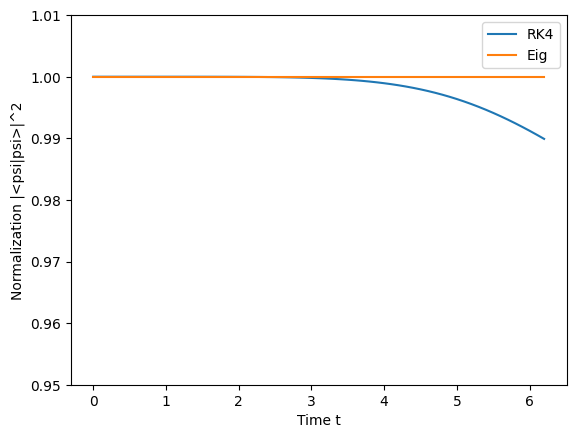

In [5]:
import matplotlib.pyplot as plt

norm_rk = torch.tensor([(abs(wf_save_rk[i,...])**2).sum() for i in range(len(t_range))])
norm_eig = torch.tensor([(abs(wf_save_eig[i,...])**2).sum() for i in range(len(t_range))])

plt.plot(t_range, norm_rk, label = "RK4")
plt.plot(t_range, norm_eig, label = "Eig")
plt.ylim(0.95, 1.01)
plt.ylabel("Normalization |<psi|psi>|^2")
plt.xlabel("Time t")
plt.legend()

It is also exact, maintaining the normalization of the wavefunction.

Text(0.5, 0, 'Time t')

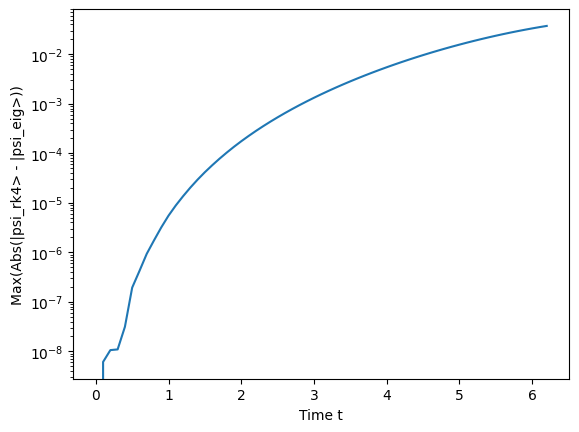

In [6]:
diff = torch.tensor([torch.max(abs(wf_save_rk[i,...] - wf_save_eig[i,...])) for i in range(len(t_range))])

plt.plot(t_range, diff)
plt.yscale("log")
plt.ylabel("Max(Abs(|psi_rk4> - |psi_eig>))")
plt.xlabel("Time t")

As we can see both methods give a similar result for small t but the difference increases exponentially due to the error in the RK4 method.

# Hamiltonian caching:
The results of hamiltonian diagonalization are cached for repeated use:

In [7]:
n_qubits: int = 10
batch_size: int = 1

qc = QuantumCircuit(n_qubits)
psi = qc.uniform_state(batch_size)
psi_ini = copy.deepcopy(psi)

H_0 = torch.randn((2**n_qubits, 2**n_qubits), dtype = torch.double)
H0 = (H_0 + torch.conj(H_0.transpose(0, 1))).cdouble()

H_1 = torch.randn((2**n_qubits, 2**n_qubits), dtype = torch.double)
H1 = (H_1 + torch.conj(H_1.transpose(0, 1))).cdouble()

In [8]:
import time

n_trials = 2
wf_save_eig = torch.zeros((n_trials,)+tuple(psi.shape)).cdouble()

print("First Hamiltonian")
for i in range(n_trials):
    H = H0
    start = time.time()
    t_evo = torch.rand(batch_size)*0.5

    psi = copy.deepcopy(psi_ini)
    hamiltonian_evolution_eig(H, psi, t_evo, range(n_qubits), n_qubits)
    wf_save_eig[i] = psi
    end = time.time()
    print("Timing:", end-start)

print("Second Hamiltonian")
for i in range(n_trials):
    H = H1
    start = time.time()
    t_evo = torch.rand(batch_size)*0.5

    psi = copy.deepcopy(psi_ini)
    hamiltonian_evolution_eig(H, psi, t_evo, range(n_qubits), n_qubits)
    wf_save_eig[i] = psi
    end = time.time()
    print("Timing:", end-start)

print("First Hamiltonian again")
for i in range(n_trials):
    H = H0
    start = time.time()
    t_evo = torch.rand(batch_size)*0.5

    psi = copy.deepcopy(psi_ini)
    hamiltonian_evolution_eig(H, psi, t_evo, range(n_qubits), n_qubits)
    wf_save_eig[i] = psi
    end = time.time()
    print("Timing:", end-start)

First Hamiltonian
Timing: 0.29912304878234863
Timing: 0.07640600204467773
Second Hamiltonian
Timing: 0.27396464347839355
Timing: 0.08124589920043945
First Hamiltonian again
Timing: 0.08870816230773926
Timing: 0.07958817481994629


# Comparing the batched hamiltonian evolution:
Here we use general hermitian matrices as hamiltonians

In [9]:
import torch
import numpy as np
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.core.operation import hamiltonian_evolution, hamiltonian_evolution_eig
from pyqtorch.core.batched_operation import batched_hamiltonian_evolution, batched_hamiltonian_evolution_eig
import copy

Let's create a batch of hamiltonians that are just repeating the same hamiltonian.

In [10]:
N = 5
batch_size = 10

qc = QuantumCircuit(N)

psi = qc.uniform_state(batch_size)
psi_0 = copy.deepcopy(psi)

H_batch = torch.zeros((2**N, 2**N, batch_size), dtype = torch.cdouble)
for i in range(batch_size):
    H_0 = torch.randn((2**N, 2**N), dtype = torch.cdouble)
    H = (H_0 + torch.conj(H_0.transpose(0, 1))).cdouble()
    H_batch[...,i] = H

Now we create a batch of linearly increasing times.

In [11]:
t_size = batch_size
t_start = 0.0
t_end = 5.0
t_evo = torch.arange(t_start, t_end, (t_end-t_start)/t_size).cdouble()

Now we evaluate the batched time-evolution, essentially evaluating the same generator for an increasing time. First with the RK4 method:

In [12]:
import time
psi = copy.deepcopy(psi_0)
start = time.time()
psi = batched_hamiltonian_evolution(H_batch, psi, t_evo, range(N), N)
end = time.time()
psi_save_rk = copy.deepcopy(psi)
print(end-start)

0.07417893409729004


And then with the eigenvalue method:

In [13]:
psi = copy.deepcopy(psi_0)
start = time.time()
psi = batched_hamiltonian_evolution_eig(H_batch, psi, t_evo, range(N), N)
end = time.time()
psi_save_eig = copy.deepcopy(psi)
print(end-start)

0.005017757415771484


Now we can compare the wavefunction normalization of both as t increases:

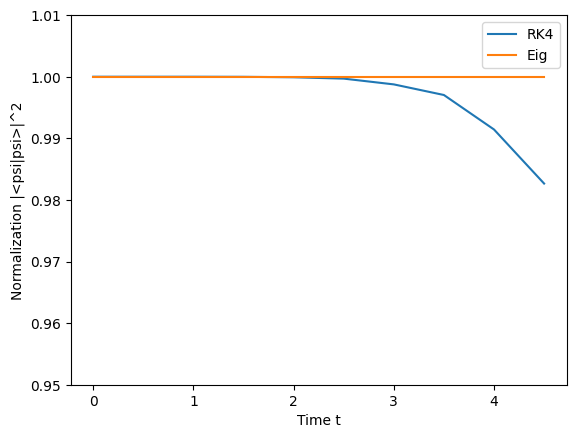

In [14]:
import matplotlib.pyplot as plt

t_range = t_evo.real

norm_rk = torch.tensor([(abs(psi_save_rk[...,b])**2).sum() for b in range(batch_size)])
norm_eig = torch.tensor([(abs(psi_save_eig[...,b])**2).sum() for b in range(batch_size)])

plt.plot(t_range, norm_rk, label = "RK4")
plt.plot(t_range, norm_eig, label = "Eig")
plt.ylim(0.95, 1.01)
plt.ylabel("Normalization |<psi|psi>|^2")
plt.xlabel("Time t")
plt.legend()

And also the difference between the wavefunctions as t increases:

Text(0.5, 0, 'Time t')

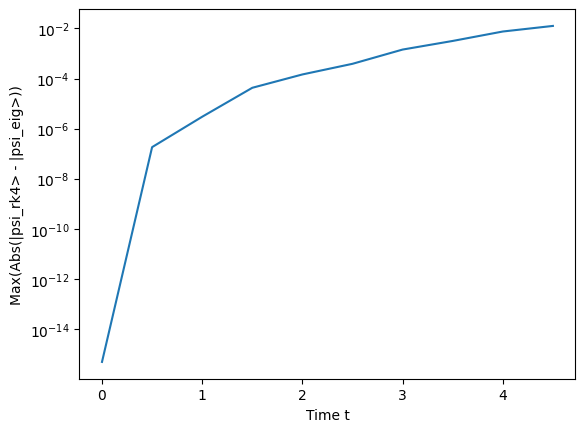

In [15]:
diff = torch.tensor([torch.max(abs(psi_save_rk[..., b] - psi_save_eig[..., b])) for b in range(batch_size)])

plt.plot(t_range, diff)
plt.yscale("log")
plt.ylabel("Max(Abs(|psi_rk4> - |psi_eig>))")
plt.xlabel("Time t")